
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 5: $k$-NN Classification, ROC, and PCA

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited.

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
pd.set_option('display.max_columns', 25)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.api import OLS

import seaborn as sns
sns.set()


## Continuing Cancer Classification from Gene Expressions

In this problem, we will continue to work with the 2-class (ALL vs. AML) cancer classification problem from homework 4. The dataset is provided in the file `data/hw4_enhance.csv` and is the same as the previous HW.  Recall: **0 indicates the ALL** class and **1 indicates the AML** class within `Cancer_type`, and columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will handle the high dimensionality of this problem directly by applying Principal Component Analysis (PCA), and then use the resulting PCA-transformed in logistic regression and $k$-NN modeling.

<div class='exercise'><b> Question 1 [20 pts]: Baseline Modeling </b></div>

First step is to split the observations into an approximate 80-20 train-test split.  Below is the same code from HW4 to do this for you (we again want to make sure everyone has the same splits). Use the training data set to answer the following questions:


**First step is to split the observations into an approximate 80-20 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). `Cancer_type` is again our target column.**

In [23]:
np.random.seed(10)
df = pd.read_csv('data/hw4_enhance.csv', index_col=0)

X_train, X_test, y_train, y_test =train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

**1.1** Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.

**1.2** Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.

**1.3** Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  Report the classification accuracy on both the train and test sets.

**1.4** Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `k = 1,2,5,10,20,50,100,200,500`. 

**1.5** Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.


<hr>

### Solutions

**1.1 Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.**

In [24]:
# your code here
X_train_norm = (X_train - X_train.min(axis=0)) / (X_train.max(axis=0) - X_train.min(axis=0))
X_test_norm = (X_test - X_train.min(axis=0)) / (X_train.max(axis=0) - X_train.min(axis=0))

**1.2 Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.**

In [26]:
# your code here
unregLR = LogisticRegression(C=100000, solver="lbfgs", max_iter=10000).fit(X_train_norm, y_train)
print(unregLR.score(X_train_norm, y_train), unregLR.score(X_test_norm, y_test))

1.0 0.7682119205298014


**1.3 Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  eport the misclassification rate on both the train and test sets.**

In [27]:
# your code here
regLR = LogisticRegressionCV(Cs=5, solver='liblinear', penalty='l1').fit(X_train_norm, y_train)
print(regLR.score(X_train_norm, y_train), regLR.score(X_test_norm, y_test))

0.9534109816971714 0.847682119205298


**1.4 Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `ks = [1,2,3,4,5,7,9,10,15,25]`.  Report your chosen $k$, and report the misclassification rate on both the train and test sets for the model using your chosen $k$.**

In [28]:
# your code here
ks = [1,2,3,4,5,7,9,10,15,25]
scores = np.zeros(len(ks))

for i, k in enumerate(ks):
    knn = KNeighborsClassifier(k)
    scores[i] = np.mean(cross_val_score(knn, X_train_norm, y_train))
print(ks[scores.argmax()])

7


In [29]:
knn = KNeighborsClassifier(ks[scores.argmax()]).fit(X_train_norm, y_train)
print(knn.score(X_train_norm, y_train), knn.score(X_test_norm, y_test))

0.9018302828618968 0.8609271523178808


**1.5 Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.**

In [30]:
# your code here
for model in [unregLR, regLR, knn]:
    preds = model.predict(X_test_norm)
    print(metrics.confusion_matrix(y_test, preds))

[[64 13]
 [22 52]]
[[67 10]
 [13 61]]
[[67 10]
 [11 63]]


*your answer here* All models seem to have more false negatives than false positives


<div class='exercise'><b> Question 2 [20 pts]: Performing Principal Components Analysis </b></div>

**2.1** Create the full PCA decomposition of `X_train` and apply the transformation to both `X_train` and `X_test`.  Report the shape of both of these.  What is the limiting factor for the maximum number of PCA components for this data set? 

**2.2** PCA is often solely used to help in visualizing high-dimensional problems.  Plot the scatterplot of the second PCA vector of train on the $Y$-axis and the first PCA vector of train on the $X$-axis (be sure to denote the classes via different color/markings).  In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.

**2.3** Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).

**2.4** Plot explained variability in the predictors on the $Y$-axis and the PCA component number on the $X$-axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony and justify your choice with 1-3 sentences.

<hr>

### Solutions

**2.1 Create the full PCA decomposition of X_train and apply the transformation to both X_train and X_test. Report the shape of both of these. What is the limiting factor for the maximum number of PCA components for this data set?**

In [25]:
# your code here
pca = PCA().fit(X_train_norm)


# apply the pca transformation to the full predictor set
pcaXtrain = pca.transform(X_train_norm)
pcaXtest = pca.transform(X_test_norm)
print(X_train_norm.shape, X_test_norm.shape)
print(pcaXtrain.shape, pcaXtest.shape)

(601, 7129) (151, 7129)
(601, 601) (151, 601)


*Your answer here* maximum number of PCA components is limited by the minimum between number of predictors and number of samples. max(n_components) = min(n_samples, n_features)


**2.2 PCA is often solely used to help in visualizing high-dimensional problems. Plot the scatterplot of the second PCA vector on the  𝑌 -axis and the first PCA vector on the  𝑋 -axis (be sure to denote the classes via different color/markings). In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.**

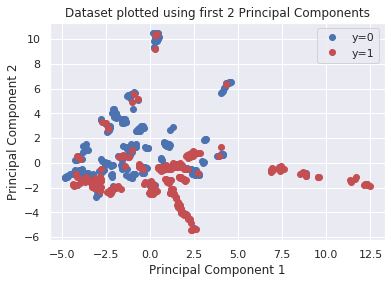

In [25]:
# your code here
vecs = pca.components_[0:2].T*2

fig, ax = plt.subplots()
ax.plot(pcaXtrain[:,0][y_train==0], pcaXtrain[:,1][y_train==0], 'bo', label="y=0")
ax.plot(pcaXtrain[:,0][y_train==1], pcaXtrain[:,1][y_train==1], 'ro', label="y=1")
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Dataset plotted using first 2 Principal Components')
ax.legend()

*your answer here*
1) it is hard to visualize high-dimensional data
2) enables us to see if there is clear distinction between classes in 2D


**2.3 Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).**

In [27]:
pca.explained_variance_ratio_[:2]

array([0.06381447, 0.04909572])

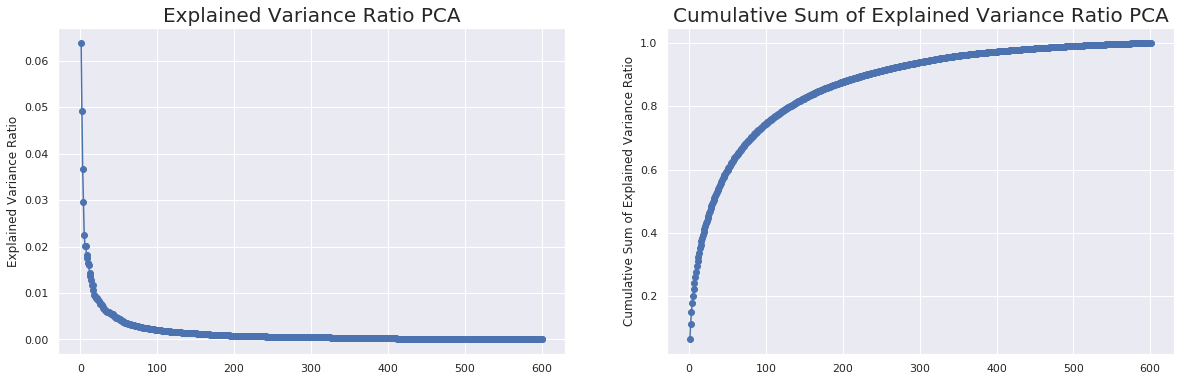

In [26]:
# your code here
fig, ax = plt.subplots(ncols=2, figsize=(20,6))
ax1, ax2 = ax.ravel()

ratio = pca.explained_variance_ratio_
ax1.plot(range(1,len(ratio)+1), ratio, 'o-')
ax1.set_title('Explained Variance Ratio PCA', fontsize=20)
ax1.set_ylabel('Explained Variance Ratio')

ratio = pca.explained_variance_ratio_
ax2.plot(range(1,len(ratio)+1), np.cumsum(ratio), 'o-')
ax2.set_title('Cumulative Sum of Explained Variance Ratio PCA', fontsize=20)
ax2.set_ylabel('Cumulative Sum of Explained Variance Ratio');

#### Roughly 10% of variance is explained by the first two components. Need around 250 components to have 90% variability explained.

**2.4 Plot explained variability in the predictors on the  𝑌 -axis and the PCA component number on the 𝑋 -axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony and ustify your choice in 1-3 sentences.**

#### 70% variability should be sufficient to represent the data. Use around 70 components.

<div class='exercise'><b> Question 3 [30 pts]: Principal Components Regression (PCR) </b></div>

**3.1** Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set. How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?

**3.2** Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`.

**3.3** Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs (and may be prefered) from evaluating models based on misclassification rate (as you have done thus far in this problem set).

**3.4** Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.

**3.5** Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction?  If you were to predict real cancer patients, how would use these models to predict cancer type?

<hr>

### Solutions

**3.1 Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set.  How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?**

In [46]:
# your code here
LR2 = LogisticRegressionCV(max_iter=10000).fit(pcaXtrain[:, :2], y_train)
LR90 = LogisticRegressionCV(max_iter=10000).fit(pcaXtrain[:, :250], y_train)

In [50]:
LR140 = LogisticRegressionCV(max_iter=10000).fit(pcaXtrain[:, :70], y_train)
print(LR140.score(pcaXtrain[:, :70], y_train), LR140.score(pcaXtest[:, :70], y_test))

0.9018302828618968 0.8675496688741722


In [49]:
print(LR2.score(pcaXtrain[:, :2], y_train), LR2.score(pcaXtest[:, :2], y_test))
print(LR90.score(pcaXtrain[:, :250], y_train), LR90.score(pcaXtest[:, :250], y_test))

0.7670549084858569 0.7748344370860927
0.9034941763727121 0.8675496688741722


*your answer here*
2 components is too few, so accuracy drops. 80% is sufficient and accuracy exceeds models from Q1.

**3.2 Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`**.

In [52]:
# your code here
idx = df.columns.get_loc("M31523_at")
print(pca.components_[:70, idx].shape)
print(LR140.coef_.shape)
print(np.dot(LR140.coef_, pca.components_[:70, idx]))

(70,)
(1, 70)
[-0.00740879]


#### a unit increase of M31523_at reduces the log odds of cancer_type by 0.0074. Log odd because we use the logistic function. This corresponds to 1/(1+ e^(-0.0074)) = 0.502 odds.

**3.3 Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs (and may be prefered) from evaluating models based on misclassification rate (as you have done thus far in this problem set).**

*your answer here* ROC (Receiver Operating Curve) plots the True Positive (TP) against the False Positive (FP). An ideal ROC should hug the top-left corner, to maximize AUC. AUC would try to ensure a balance between trying to get as many TPs as possible while maintaining few FPs, compared to accuracy which only cares about getting TPs and TNs right.

**3.4 Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the best model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.**

In [54]:
# your code here
aucs = np.zeros(6)
for i, model in enumerate([unregLR, regLR, knn]):
    y_score = model.predict_proba(X_test_norm)[:,1]
    aucs[i] = metrics.roc_auc_score(y_test, y_score)

comps = [2, 70, 250]
for i, model in enumerate([LR2, LR140, LR90]):
    y_score = model.predict_proba(pcaXtest[:, :comps[i]])[:,1]
    aucs[i+3] = metrics.roc_auc_score(y_test, y_score)

In [56]:
aucs.argmax()  # knn
y_score = knn.predict_proba(X_test_norm)[:, 1]

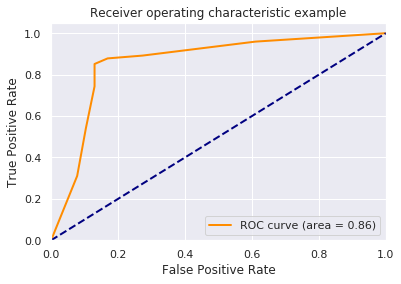

In [57]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % aucs.max())
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

*your answer here*

**3.5 Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction? If you were to predict real cancer patients, how would use these models to predict cancer type?**

In [58]:
print(aucs)

[0.8470516  0.85784486 0.85977536 0.82116532 0.85117585 0.85012285]


*your answer here*
A lot of models with similar prediction.
Use an ensemble of models.

<div class='exercise'><b> Question 4: COMPAS [30 points] </b></div>

This problem is unrelated to the first 3 problems, and steps through analyzing the COMPAS data set `compas.csv`.  The variables are roughly explained in the `compas_datadict.csv` file, and ProPublica's analysis is publically available here: https://github.com/propublica/compas-analysis.

**4.1** Split the data into 80% training and 20% test stratified by race. Before splitting you may want to process the categorical predictors first so you don't have to do it separately in tain and test later.

**4.2** Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.

**4.3** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?  Explain in 3-5 sentences.

**4.4**. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models: $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor. 

**4.5**. Refit the models in 4.4 without race as a predictor.  Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set.  How do these compare to the models when race is included as a predictor?

**4.6**. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.

<hr>

### Solutions

**4.1 Split the data into 80% training and 20% test stratified by race.  Before splitting you may want to process the categorical predictors first so you don't have to do it separately in tain and test later.**

In [156]:
compas_df = pd.read_csv('data/compas.csv')

# your code here
cols = ["c_charge_degree", "race", "score_text", "sex"]
compas_df = pd.get_dummies(compas_df, columns=cols, drop_first=True)
compas_df.head()

,age,c_charge_desc,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,two_year_recid,length_of_stay,priors_1,priors_234,priors_5plus,...,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh,c_charge_degree_M,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,score_text_Low,score_text_Medium,sex_Male
0,69,Aggravated Assault w/Firearm,0,0,0,0,1,0,1,0,0,0,...,1,0,1,0,0,0,0,0,1,1,0,1
1,34,Felony Battery w/Prior Convict,0,0,0,0,3,1,10,0,0,0,...,1,0,10,0,0,0,0,0,0,1,0,1
2,24,Possession of Cocaine,4,0,0,1,4,1,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1,0,1
3,44,Battery,0,0,0,0,1,0,1,0,0,0,...,1,0,1,1,0,0,0,0,1,1,0,1
4,41,Possession Burglary Tools,14,0,0,0,6,1,6,0,0,1,...,0,1,6,0,0,1,0,0,0,0,1,1


**4.2 Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.**

In [157]:
# your code here
afro_idx = (compas_df.race_Asian == 0) & (compas_df.race_Caucasian == 0) & (compas_df.race_Hispanic == 0) \
            & (compas_df["race_Native American"] == 0) & (compas_df.race_Other == 0)
afro_df = compas_df[afro_idx]

white_idx = (compas_df.race_Caucasian == 1)
white_df = compas_df[white_idx]

In [158]:
diff_vars = ["decile_score", "length_of_stay", "juv_fel_count"]
print(white_df[diff_vars].describe())
print(afro_df[diff_vars].describe())

       decile_score  length_of_stay  juv_fel_count
count   2103.000000     2103.000000    2103.000000
mean       3.635283       12.284356       0.025202
std        2.562748       38.410547       0.298796
min        1.000000        0.000000       0.000000
25%        1.000000        1.000000       0.000000
50%        3.000000        1.000000       0.000000
75%        5.000000        6.000000       0.000000
max       10.000000      530.000000       8.000000
       decile_score  length_of_stay  juv_fel_count
count   3175.000000     3175.000000    3175.000000
mean       5.276850       17.823307       0.085354
std        2.828073       53.310346       0.468231
min        1.000000        0.000000       0.000000
25%        3.000000        1.000000       0.000000
50%        5.000000        1.000000       0.000000
75%        8.000000        7.000000       0.000000
max       10.000000      800.000000      10.000000


**4.3 With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences? Explain in 3-5 sentences.**

*your answer here*
As seen in the counts for the two sub-datasets, black criminals outnumber whites by 1000+. This introduces bias as it seems that blacks commit more crimes.

**4.4. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models:  $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor.**

In [159]:
races = ["race_Asian","race_Caucasian","race_Hispanic","race_Native American","race_Other"]
predictors = diff_vars + races

In [160]:
# your code here
X = compas_df[predictors]
y = compas_df["two_year_recid"]

itrain, itest = train_test_split(range(len(compas_df)), test_size=0.2)
print(predictors)

X_train = X.iloc[itrain]
y_train = y.iloc[itrain]
print(X_train.shape)

['decile_score', 'length_of_stay', 'juv_fel_count', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other']
(4937, 8)


In [161]:
LR = LogisticRegressionCV().fit(X_train, y_train)
knn = KNeighborsClassifier().fit(X_train, y_train)

In [162]:
X_test = X.iloc[itest]
y_test = y.iloc[itest]

In [163]:
print(LR.score(X_test, y_test), knn.score(X_test, y_test))

0.6591093117408907 0.5975708502024292


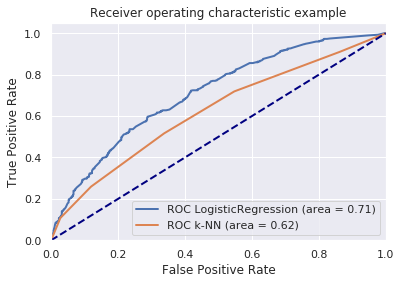

In [164]:
plt.figure()
lw = 2
for name, model in [("LogisticRegression", LR), ("k-NN", knn)]:
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
    auc = metrics.roc_auc_score(y_test, y_score)
    plt.plot(fpr, tpr, lw=lw, label='ROC %s (area = %0.2f)' % (name, auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [165]:
afro_test = ((compas_df.race_Asian == 0) & (compas_df.race_Caucasian == 0) & (compas_df.race_Hispanic == 0) \
            & (compas_df["race_Native American"] == 0) & (compas_df.race_Other == 0))[itest]
white_test = (compas_df.race_Caucasian == 0)[itest]

In [167]:
for name, model in [("LogisticRegression", LR), ("k-NN", knn)]:
    preds = model.predict(X_test)
    print(name + " confusion matrix with race (Afro):")
    print(metrics.confusion_matrix(y_test[afro_test], preds[afro_test]))
    print(name + " confusion matrix with race (White):")
    print(metrics.confusion_matrix(y_test[white_test], preds[white_test]))

LogisticRegression confusion matrix with race (Afro):
[[197 103]
 [113 210]]
LogisticRegression confusion matrix with race (White):
[[301 117]
 [164 229]]
k-NN confusion matrix with race (Afro):
[[167 133]
 [132 191]]
k-NN confusion matrix with race (White):
[[255 163]
 [170 223]]


**4.5. Refit the models in 4.4 without race as a predictor. Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set. How do these compare to the models when race is included as a predictor?**

In [168]:
# your code here
X = compas_df[diff_vars]
X_train = X.iloc[itrain]
print(X_train.shape)

(4937, 3)


In [169]:
LR = LogisticRegressionCV().fit(X_train, y_train)
knn = KNeighborsClassifier().fit(X_train, y_train)

In [170]:
X_test = X.iloc[itest]

In [171]:
print(LR.score(X_test, y_test), knn.score(X_test, y_test))

0.6591093117408907 0.6121457489878542


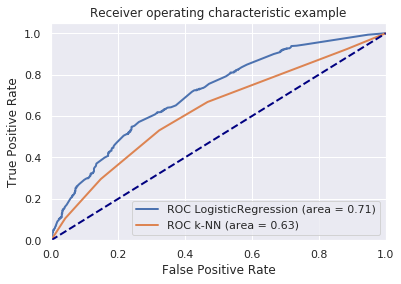

In [172]:
plt.figure()
lw = 2
for name, model in [("LogisticRegression", LR), ("k-NN", knn)]:
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
    auc = metrics.roc_auc_score(y_test, y_score)
    plt.plot(fpr, tpr, lw=lw, label='ROC %s (area = %0.2f)' % (name, auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [175]:
for name, model in [("LogisticRegression", LR), ("k-NN", knn)]:
    preds = model.predict(X_test)
    print(name + " confusion matrix without race (Afro):")
    print(metrics.confusion_matrix(y_test[afro_test], preds[afro_test]))
    print(name + " confusion matrix without race (White):")
    print(metrics.confusion_matrix(y_test[white_test], preds[white_test]))

LogisticRegression confusion matrix without race (Afro):
[[197 103]
 [113 210]]
LogisticRegression confusion matrix without race (White):
[[302 116]
 [164 229]]
k-NN confusion matrix without race (Afro):
[[168 132]
 [132 191]]
k-NN confusion matrix without race (White):
[[265 153]
 [174 219]]


#### Accuracy and AUC are pretty much the same for 5-NN and logistic regression, regardless of whether race was a predictor.  Not much difference in TPR and FPR either.

**4.6. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.**

*your answer here*
Lots of variables correlate with race. Removing race does not remove the effects of race from the model.
Omitting race does not solve the problem of false-positive rates and false-negative rates being different for the two different races in question

---